# INITIAL SET UP

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [4]:
# Import other libraries
import matplotlib.pyplot as plt
plt.rc('font', size=16)
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

#DATA LOADING

In [34]:
%cd /content/drive/MyDrive/Challenge1/Challenge1_Luca

/content/drive/MyDrive/Challenge1/Challenge1_Luca


In [36]:
# Load the dataset
dataset = np.load('../extracted_data/public_data.npz', allow_pickle=True)

print(dataset.files)

['data', 'labels']


In [37]:
# Extract the arrays from the data
data = dataset['data']
labels = dataset['labels']

# Convert data and labels values into the correct data_type
data = np.array(data, dtype=np.uint8)

# add padding to the images in order to have a 224,244,3 shape. The images in input are of size 96,96,3
#data = np.array([cv2.copyMakeBorder(image, 64, 64, 64, 64, cv2.BORDER_REFLECT_101) for image in data])

print(data.shape) #the images
print(labels.shape)

(5200, 96, 96, 3)
(5200,)


#DATA SET PREPARATION

In [39]:
def get_image_hash(image):
    # Converti l'immagine in una stringa
    image_string = image.tobytes()

    # Calcola la somma dei valori dei byte
    hash_value = sum(image_string)

    return hash_value

# Compute hash for each image
hashes = np.array([get_image_hash(image) for image in data])

# Find unique hashes and their indices
unique_hashes, indices = np.unique(hashes, return_index=True)

# Select the unique images and their corresponding labels
data_unique = data[indices]
labels_unique = labels[indices]


print(f"Original dataset size: {data.shape[0]}")
print(f"Unique dataset size: {data_unique.shape[0]}")

Original dataset size: 5200
Unique dataset size: 4849


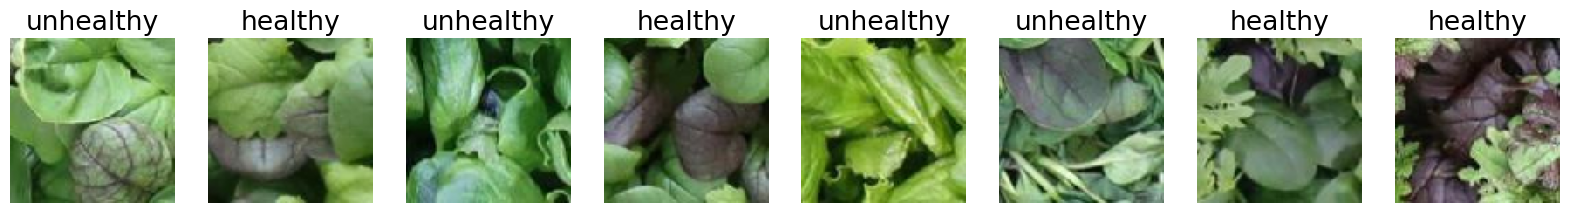

In [8]:
# randomize the choice of images at each run
seed = random.randint(0, 1000)
random.seed(seed)
fig, ax = plt.subplots(1, 8, figsize=(20, 20))
for i in range(8):
    random_index = random.randint(0, data_unique.shape[0])
    ax[i].imshow(data_unique[random_index])
    ax[i].set_title(labels_unique[random_index])
    ax[i].axis('off')
plt.show()

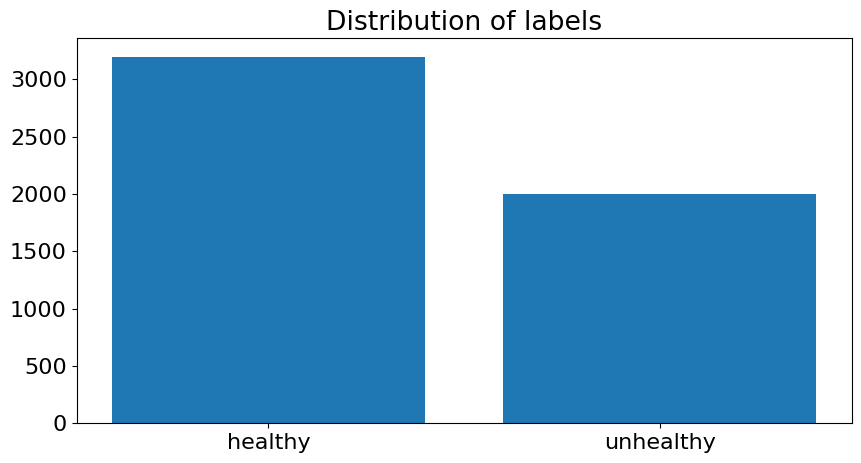

In [9]:
from collections import Counter

counter_labels = Counter(labels)
labels_count, counts = zip(*counter_labels.items())

plt.figure(figsize=(10, 5))
plt.bar(labels_count, counts)
plt.title('Distribution of labels')
plt.show()

## Upsampling

In [40]:
# Find the indices of the healthy and unhealthy images
healthy_indices = np.where(labels_unique == 'healthy')[0]
unhealthy_indices = np.where(labels_unique == 'unhealthy')[0]

# Determine the number of images to sample from the unhealthy class to match the healthy class
num_samples = len(healthy_indices)

random_unhealthy_indices = np.random.choice(unhealthy_indices, size=(num_samples - len(unhealthy_indices)), replace=True)
random_unhealthy_images = data_unique[random_unhealthy_indices]
random_unhealthy_labels = labels_unique[random_unhealthy_indices]

# perform horizontal and vertical flipping and a 0.3 angle rotation on random_unhealthy_images
flip = tf.keras.Sequential([tfkl.RandomFlip("horizontal"), tfkl.RandomFlip("vertical"), tfkl.RandomRotation(0.3)])
random_unhealthy_images = np.array(flip(random_unhealthy_images), dtype=np.uint8)

# Concatenate the random unhealthy images and labels with the labels_unique and data_unique
data_balanced = np.concatenate([data_unique, random_unhealthy_images])
labels_balanced = np.concatenate([labels_unique, random_unhealthy_labels])

# Shuffle the data and labels so that the labels still correspond to the data
indices = np.arange(data_balanced.shape[0])
np.random.shuffle(indices)
data_balanced = data_balanced[indices]
labels_balanced = labels_balanced[indices]

print(data_balanced.shape)
print(labels_balanced.shape)

(6120, 96, 96, 3)
(6120,)


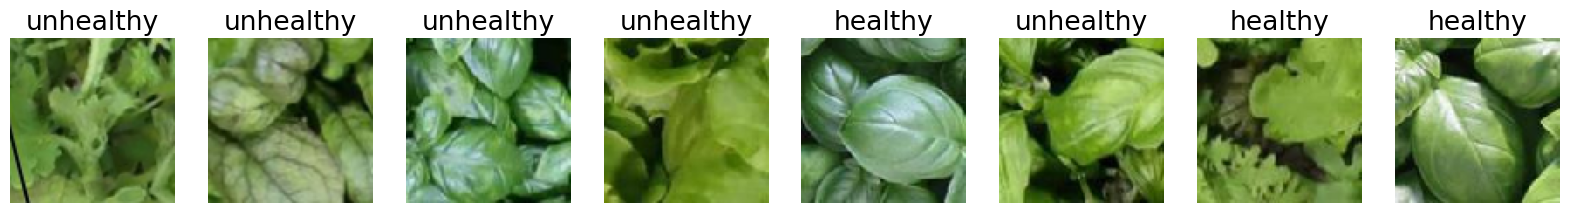

In [11]:
# randomize the choice of images at each run
seed = random.randint(0, 1000)
random.seed(seed)
fig, ax = plt.subplots(1, 8, figsize=(20, 20))
for i in range(8):
    random_index = random.randint(0, data_balanced.shape[0])
    ax[i].imshow(data_balanced[random_index])
    ax[i].set_title(labels_balanced[random_index])
    ax[i].axis('off')
plt.show()

# DATA SET SPLITTING

In [41]:
# Convert labels to one-hot encoding
label_mapping = {'healthy': 0, 'unhealthy': 1}
numeric_labels = [label_mapping[label] for label in labels_balanced]
one_hot_labels = np.array(numeric_labels)

In [42]:
# Split the data into train_val and test sets
train_data, val_data, train_labels, val_labels = train_test_split(data_balanced, one_hot_labels, test_size=0.15, random_state=seed, stratify=one_hot_labels)


# Print the shape of the train, val and test sets
print(train_data.shape, train_labels.shape)
print(val_data.shape, val_labels.shape)

(5202, 96, 96, 3) (5202,)
(918, 96, 96, 3) (918,)


# RESNET152V2 MODEL

## TRANSFER LEARNING

In [46]:
# Define the input shape, output shape, batch size and the number of epochs
input_shape = train_data.shape[1:]
output_shape = len(np.unique(one_hot_labels))
batch_size = 32
epochs = 100

resnet_model = tfk.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=input_shape)

# Display the model architecture with input shapes
tfk.utils.plot_model(resnet_model, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [47]:
data_augmentation = tfk.Sequential([
    #tfkl.Rescaling(1./255),
    tfkl.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
    tfkl.RandomRotation(0.2),
    #tfkl.RandomZoom(0.2),
    #tfkl.RandomBrightness(0.2, seed=seed),
    tfkl.RandomContrast(0.2, seed=seed)
], name = "data_augmentation")

In [48]:
model = tfk.Sequential([
    tfkl.Input(shape=input_shape),
    data_augmentation,
    tf.keras.layers.Lambda(tf.keras.applications.convnext.preprocess_input, name='supernet_preprocessing'),
    convNeXt_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(1e-3), kernel_initializer=tfk.initializers.HeUniform(seed)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(1e-3), kernel_initializer=tfk.initializers.HeUniform(seed)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed), name='output_layer')
], name='ResNet')

# Compile the model for binary classification
model.compile(optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
              loss=tfk.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


In [ ]:
model.summary()

In [49]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=6, factor=0.5, min_lr=5e-5, verbose=1)

callbacks = [rlrop, early_stopping]

In [50]:
# Train the model
history = model.fit(
    x = train_data,
    y = train_labels,
    batch_size = 32,
    epochs = 200,
    validation_data = (val_data, val_labels),
    shuffle = True,
    callbacks = callbacks
    #callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)]
).history

# Save the trained model
#model.save('/content/drive/MyDrive/Challenge1/Challenge1_Filippo/ResNet-96')

Epoch 1/200
163/163 [==============================] - 134s 284ms/step - loss: 132.9043 - accuracy: 0.6126 - val_loss: 88.6102 - val_accuracy: 0.7495 - lr: 1.0000e-04
Epoch 2/200
163/163 [==============================] - 40s 247ms/step - loss: 64.0304 - accuracy: 0.7407 - val_loss: 44.1990 - val_accuracy: 0.7484 - lr: 1.0000e-04
Epoch 3/200
163/163 [==============================] - 44s 268ms/step - loss: 32.0471 - accuracy: 0.7951 - val_loss: 22.7784 - val_accuracy: 0.7712 - lr: 1.0000e-04
Epoch 4/200
163/163 [==============================] - 39s 238ms/step - loss: 17.3522 - accuracy: 0.8243 - val_loss: 13.3709 - val_accuracy: 0.7767 - lr: 1.0000e-04
Epoch 5/200
163/163 [==============================] - 39s 241ms/step - loss: 10.8220 - accuracy: 0.8378 - val_loss: 9.0704 - val_accuracy: 0.7440 - lr: 1.0000e-04
Epoch 6/200
163/163 [==============================] - 39s 241ms/step - loss: 7.5354 - accuracy: 0.8441 - val_loss: 6.4157 - val_accuracy: 0.8246 - lr: 1.0000e-04
Epoch 7/200

In [53]:
%cd /content/drive/MyDrive/Challenge1/Challenge1_Luca

/content/drive/MyDrive/Challenge1/Challenge1_Luca


In [ ]:
model.save('ResnetV1TL')
del model

In [51]:
max_accuracy = max(history['accuracy'])
max_val_accuracy = max(history['val_accuracy'])

print(f"Maximum training accuracy: {max_accuracy}")
print(f"Maximum validation accuracy: {max_val_accuracy}")

Maximum training accuracy: 0.9665513038635254
Maximum validation accuracy: 0.915032684803009


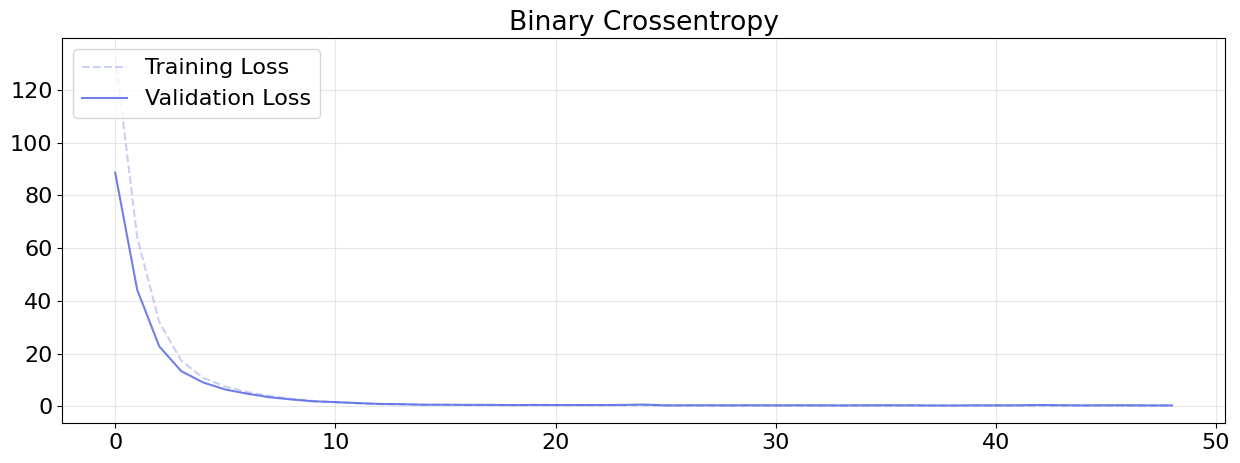

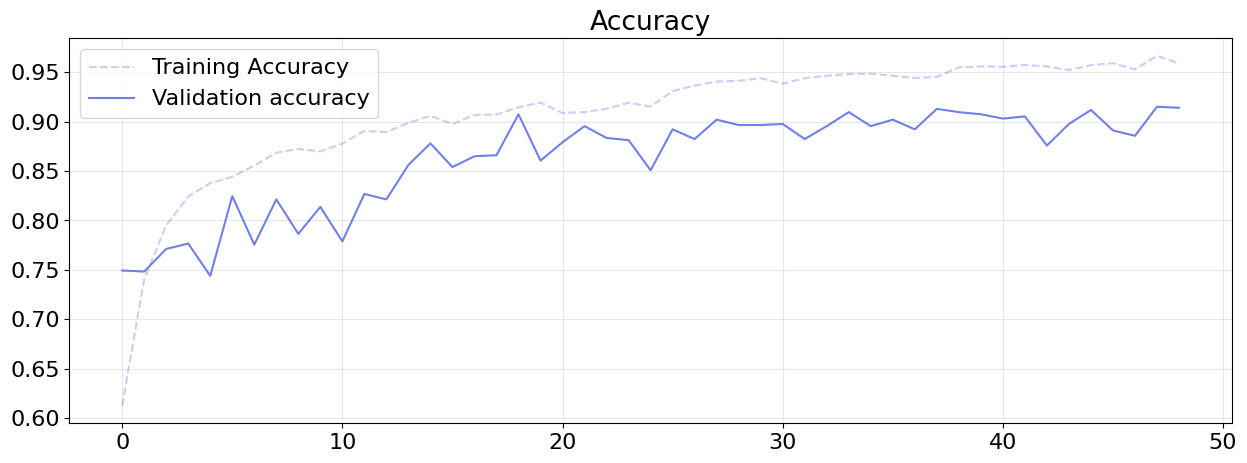

In [52]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## FINE TUNING

In [2]:
#load model after transfer learning
ft_model = tfk.models.load_model('ResnetV1TL')

NameError: ignored

In [ ]:
ft_model.summary()
print("Number of layers in the base model: ", len(ft_model.get_layer(convNeXt_model.name).layers))

Unfreeze Layers corresponding to the first 2 blocks

In [ ]:
model.summary()

In [55]:
ft_model.get_layer('resnet152v2').trainable = True

for i, layer in enumerate(ft_model.get_layer('resnet152v2').layers):
  print(i, layer.name, layer.trainable)


0 input_1 True
1 conv1_pad True
2 conv1_conv True
3 pool1_pad True
4 pool1_pool True
5 conv2_block1_preact_bn True
6 conv2_block1_preact_relu True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_pad True
11 conv2_block1_2_conv True
12 conv2_block1_2_bn True
13 conv2_block1_2_relu True
14 conv2_block1_0_conv True
15 conv2_block1_3_conv True
16 conv2_block1_out True
17 conv2_block2_preact_bn True
18 conv2_block2_preact_relu True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_pad True
23 conv2_block2_2_conv True
24 conv2_block2_2_bn True
25 conv2_block2_2_relu True
26 conv2_block2_3_conv True
27 conv2_block2_out True
28 conv2_block3_preact_bn True
29 conv2_block3_preact_relu True
30 conv2_block3_1_conv True
31 conv2_block3_1_bn True
32 conv2_block3_1_relu True
33 conv2_block3_2_pad True
34 conv2_block3_2_conv True
35 conv2_block3_2_bn True
36 conv2_block3_2_relu True
37 max_pooling2d True

In [56]:
#freeze the first 528 layer
for layer in ft_model.get_layer('resnet152v2').layers[:516]:
    layer.trainable = False

unfreezed = 0
for i in reversed(range(len(ft_model.get_layer(convNeXt_model.name).layers))):
    layer = ft_model.get_layer(convNeXt_model.name).layers[i]
    print(i, layer.name, layer.trainable)

563 post_relu True
562 post_bn True
561 conv5_block3_out True
560 conv5_block3_3_conv True
559 conv5_block3_2_relu True
558 conv5_block3_2_bn True
557 conv5_block3_2_conv True
556 conv5_block3_2_pad True
555 conv5_block3_1_relu True
554 conv5_block3_1_bn True
553 conv5_block3_1_conv True
552 conv5_block3_preact_relu True
551 conv5_block3_preact_bn True
550 conv5_block2_out True
549 conv5_block2_3_conv True
548 conv5_block2_2_relu True
547 conv5_block2_2_bn True
546 conv5_block2_2_conv True
545 conv5_block2_2_pad True
544 conv5_block2_1_relu True
543 conv5_block2_1_bn True
542 conv5_block2_1_conv True
541 conv5_block2_preact_relu True
540 conv5_block2_preact_bn True
539 conv5_block1_out True
538 conv5_block1_3_conv True
537 conv5_block1_0_conv True
536 conv5_block1_2_relu True
535 conv5_block1_2_bn True
534 conv5_block1_2_conv True
533 conv5_block1_2_pad True
532 conv5_block1_1_relu True
531 conv5_block1_1_bn True
530 conv5_block1_1_conv True
529 conv5_block1_preact_relu True
528 conv5_

In [57]:
unfreezed = 0
for i in reversed(range(len(ft_model.get_layer(convNeXt_model.name).layers))):
    layer = ft_model.get_layer(convNeXt_model.name).layers[i]
    if unfreezed < 670 and not isinstance(layer, tfk.layers.BatchNormalization):
        unfreezed += 1
        layer.trainable = True
    else:
        layer.trainable = False
    print(i, layer.name, layer.trainable)

ft_model.summary()

563 post_relu True
562 post_bn False
561 conv5_block3_out True
560 conv5_block3_3_conv True
559 conv5_block3_2_relu True
558 conv5_block3_2_bn False
557 conv5_block3_2_conv True
556 conv5_block3_2_pad True
555 conv5_block3_1_relu True
554 conv5_block3_1_bn False
553 conv5_block3_1_conv True
552 conv5_block3_preact_relu True
551 conv5_block3_preact_bn False
550 conv5_block2_out True
549 conv5_block2_3_conv True
548 conv5_block2_2_relu True
547 conv5_block2_2_bn False
546 conv5_block2_2_conv True
545 conv5_block2_2_pad True
544 conv5_block2_1_relu True
543 conv5_block2_1_bn False
542 conv5_block2_1_conv True
541 conv5_block2_preact_relu True
540 conv5_block2_preact_bn False
539 conv5_block1_out True
538 conv5_block1_3_conv True
537 conv5_block1_0_conv True
536 conv5_block1_2_relu True
535 conv5_block1_2_bn False
534 conv5_block1_2_conv True
533 conv5_block1_2_pad True
532 conv5_block1_1_relu True
531 conv5_block1_1_bn False
530 conv5_block1_1_conv True
529 conv5_block1_preact_relu True
5

In [58]:
ft_model.compile(optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
              loss=tfk.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [59]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 6, factor= 0.5, min_lr= 1e-5, verbose=1)

callbacks = [rlrop, early_stopping]

In [60]:
ft_history = ft_model.fit(
    x = train_data,
    y = train_labels,
    batch_size = batch_size,
    epochs = 100,
    validation_data = (val_data, val_labels),
    shuffle = True,
    callbacks = callbacks
).history

Epoch 1/100
163/163 [==============================] - 82s 256ms/step - loss: 0.8398 - accuracy: 0.7536 - val_loss: 0.7534 - val_accuracy: 0.8355 - lr: 1.0000e-04
Epoch 2/100
163/163 [==============================] - 38s 234ms/step - loss: 0.6194 - accuracy: 0.8476 - val_loss: 0.7544 - val_accuracy: 0.8257 - lr: 1.0000e-04
Epoch 3/100
163/163 [==============================] - 38s 232ms/step - loss: 0.5408 - accuracy: 0.8818 - val_loss: 0.5650 - val_accuracy: 0.8606 - lr: 1.0000e-04
Epoch 4/100
163/163 [==============================] - 38s 232ms/step - loss: 0.5340 - accuracy: 0.8810 - val_loss: 0.5089 - val_accuracy: 0.8867 - lr: 1.0000e-04
Epoch 5/100
163/163 [==============================] - 37s 229ms/step - loss: 0.4972 - accuracy: 0.8948 - val_loss: 0.6305 - val_accuracy: 0.8671 - lr: 1.0000e-04
Epoch 6/100
163/163 [==============================] - 38s 234ms/step - loss: 0.5064 - accuracy: 0.8941 - val_loss: 0.7135 - val_accuracy: 0.7680 - lr: 1.0000e-04
Epoch 7/100
163/163 [=

In [ ]:
#ft_model.save('Resnet152v2fine_tuned')

In [1]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

NameError: ignored